# Mall Customers

In [1]:
# standard imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# custom imports
from env import host, user, password

## 1.

Acquire data from mall_customers.customers in mysql database.

In [2]:
def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

    
def new_mall_data():
    '''
    This function reads the data from the Codeup db into a df and returns the df.
    '''
    # Create SQL query.
    sql_query = """
    select * from customers;
    """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('mall_customers'))
    
    return df.set_index('customer_id')

def get_mall_data():
    '''
    This function reads in data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('mall_customers_df.csv'):
        
        # If csv file exists, read in data from csv file.
        df = pd.read_csv('mall_customers_df.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame.
        df = new_mall_data()
        
        # Write DataFrame to a csv file.
        df.to_csv('mall_customers_df.csv')
        
    return df

In [3]:
df = get_mall_data()

## 2.

Summarize data (include distributions and descriptive statistics).

In [4]:
df.shape

(200, 4)

In [5]:
df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [7]:
df.describe()

,age,annual_income,spending_score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [8]:
def plot_distributions(df):
    '''
    This function creates frequency distributions for each numerical column in the df
    '''
    plt.figure(figsize=(15, 3))
    
    # List of columns
    cols = df.select_dtypes('number').columns.tolist()
    
    for i, col in enumerate(cols):
        
        # i starts at 0, but plot nos should start at 1
        plot_number = i + 1 
        
        # Create subplot.
        plt.subplot(1,len(cols), plot_number)
        
        # Axis labels
        plt.xlabel(col)
        plt.ylabel('count')
        
        # Display histogram for column.
        df[col].hist(edgecolor='black', color='green')
        
        # Hide gridlines.
        plt.grid(False)

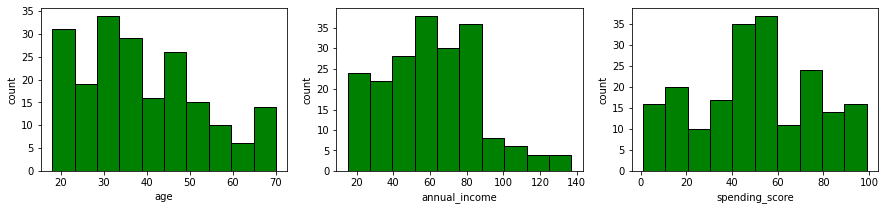

In [9]:
plot_distributions(df)

***Might be some outliers with annual income, everything else looks good***

In [10]:
def plot_boxplots(df):
    '''
    This function creates boxplots for each numerical column in the df
    '''
    plt.figure(figsize=(12, 4))

    # List of columns
    cols = df.select_dtypes('number').columns.tolist()
    
    for i, col in enumerate(cols):
        
        # i starts at 0, but plot nos should start at 1
        plot_number = i + 1 
        
        # Create subplot.
        plt.subplot(1,len(cols), plot_number)
        
        # Title with column name.
        #plt.title(col)
        
        # Display boxplot for column.
        sns.boxplot(y=col, data=df, color='green')
        plt.tight_layout()

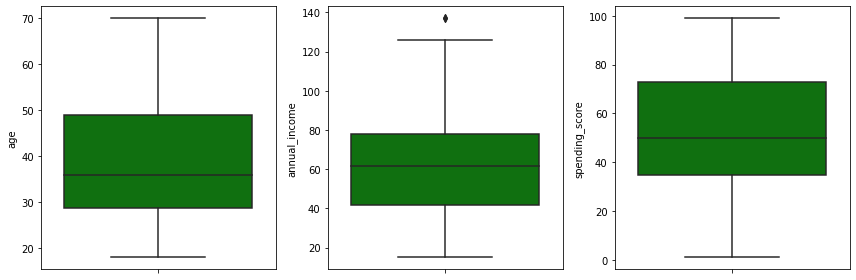

In [11]:
plot_boxplots(df)

***Are outliers present with annual income***

## 3.

Detect outliers using IQR.

In [12]:
def remove_outliers(df):
    num_cols = df.select_dtypes('number').columns.tolist()
    for col in num_cols:
        Q1 = np.percentile(df[col], 25, interpolation='midpoint')
        Q3 = np.percentile(df[col], 75, interpolation='midpoint')
        IQR = Q3 - Q1
        UB = Q3 + (1.5 * IQR)
        LB = Q1 - (1.5 * IQR)
        df = df[(df[col] < UB) & (df[col] > LB)]
    return df

In [13]:
df = remove_outliers(df)

In [14]:
df.shape

(198, 4)

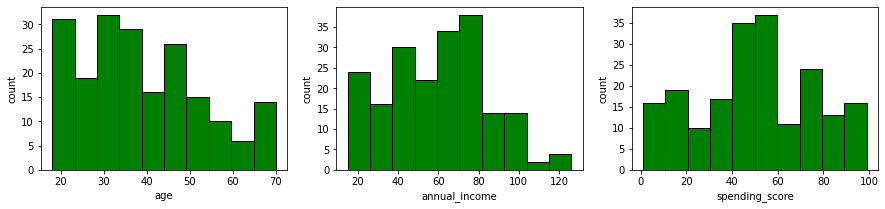

In [15]:
plot_distributions(df)

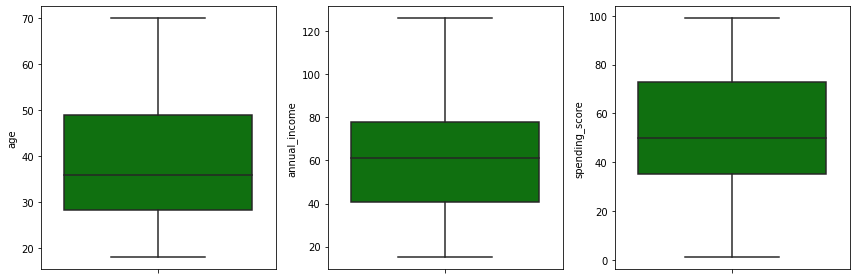

In [16]:
plot_boxplots(df)

***Outliers have been handled***

## 6.

Handles missing values.

In [17]:
df.isnull().sum()

gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

***There are no nulls to handle***

## 5.

Encode categorical columns using a one hot encoder (pd.get_dummies).

In [18]:
df_encoded = pd.get_dummies(data=df, columns=['gender'])
df_encoded.head()

,age,annual_income,spending_score,gender_Female,gender_Male
customer_id,,,,,
1,19,15,39,0,1
2,21,15,81,0,1
3,20,16,6,1,0
4,23,16,77,1,0
5,31,17,40,1,0


In [19]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 1 to 198
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             198 non-null    int64
 1   annual_income   198 non-null    int64
 2   spending_score  198 non-null    int64
 3   gender_Female   198 non-null    uint8
 4   gender_Male     198 non-null    uint8
dtypes: int64(3), uint8(2)
memory usage: 6.6 KB


## 4.

Split data (train, validate, and test split).

In [20]:
def split(df):
    '''
    This function takes in a df and splits it into train, validate, and test dfs
    final proportions will be 60/20/20 for train/validate/test
    '''
    train_validate, test = train_test_split(df, test_size=0.2, random_state=527)
    train, validate = train_test_split(train_validate, test_size=.25, random_state=527)
    return train, validate, test

In [21]:
train_exp, validate_exp, test_exp = split(df)
train_exp.shape[0] / df.shape[0], validate_exp.shape[0] / df.shape[0], test_exp.shape[0] / df.shape[0]

(0.5959595959595959, 0.20202020202020202, 0.20202020202020202)

In [22]:
train_exp.head()

,gender,age,annual_income,spending_score
customer_id,,,,
44,Female,31,39,61
74,Female,60,50,56
119,Female,51,67,43
130,Male,38,71,75
169,Female,36,87,27


In [23]:
train_mod, validate_mod, test_mod = split(df_encoded)
train_mod.shape[0] / df.shape[0], validate_mod.shape[0] / df.shape[0], test_mod.shape[0] / df.shape[0]

(0.5959595959595959, 0.20202020202020202, 0.20202020202020202)

In [24]:
train_mod.head()

,age,annual_income,spending_score,gender_Female,gender_Male
customer_id,,,,,
44,31,39,61,1,0
74,60,50,56,1,0
119,51,67,43,1,0
130,38,71,75,0,1
169,36,87,27,1,0


## 7.

Scaling

In [25]:
def add_scaled_columns(train, validate, test, scaler, columns_to_scale):
    '''
    Add scaled copies of columns to train, validate, and split
    '''
    # new column names
    new_column_names = [c + '_scaled' for c in columns_to_scale]
    
    # Fit the scaler on the train
    scaler.fit(train[columns_to_scale])
    
    # transform train validate and test
    train = pd.concat([
        train,
        pd.DataFrame(scaler.transform(train[columns_to_scale]), columns=new_column_names, index=train.index),
    ], axis=1)
    
    validate = pd.concat([
        validate,
        pd.DataFrame(scaler.transform(validate[columns_to_scale]), columns=new_column_names, index=validate.index),
    ], axis=1)
    
    
    test = pd.concat([
        test,
        pd.DataFrame(scaler.transform(test[columns_to_scale]), columns=new_column_names, index=test.index),
    ], axis=1)
    
    # drop scaled columns
    train = train.drop(columns=columns_to_scale)
    validate = validate.drop(columns=columns_to_scale)
    test = test.drop(columns=columns_to_scale)
    
    return train, validate, test

In [26]:
num_cols = df.select_dtypes('number').columns.tolist()
train_mod, validate_mod, test_mod = add_scaled_columns(train_mod, validate_mod, test_mod, MinMaxScaler(), num_cols)
train_mod.head()

,gender_Female,gender_Male,age_scaled,annual_income_scaled,spending_score_scaled
customer_id,,,,,
44,1,0,0.250000,0.216216,0.612245
74,1,0,0.807692,0.315315,0.561224
119,1,0,0.634615,0.468468,0.428571
130,0,1,0.384615,0.504505,0.755102
169,1,0,0.346154,0.648649,0.265306


In [27]:
def encode_scale(df, scaler):
    cat_cols = df.select_dtypes('object').columns.tolist()
    df = pd.get_dummies(data=df, columns=cat_cols)
    train, validate, test = split(df)
    num_cols = df.select_dtypes('int64').columns.tolist()
    new_column_names = [c + '_scaled' for c in num_cols]
    
    # Fit the scaler on the train
    scaler.fit(train[num_cols])
    
    # transform train validate and test
    train = pd.concat([
        train,
        pd.DataFrame(scaler.transform(train[num_cols]), columns=new_column_names, index=train.index),
    ], axis=1)
    
    validate = pd.concat([
        validate,
        pd.DataFrame(scaler.transform(validate[num_cols]), columns=new_column_names, index=validate.index),
    ], axis=1)
    
    
    test = pd.concat([
        test,
        pd.DataFrame(scaler.transform(test[num_cols]), columns=new_column_names, index=test.index),
    ], axis=1)
    
    # drop scaled columns
    train = train.drop(columns=num_cols)
    validate = validate.drop(columns=num_cols)
    test = test.drop(columns=num_cols)
    
    return train, validate, test

In [28]:
train_mod, validate_mod, test_mod = encode_scale(df, MinMaxScaler())
train_mod.head()

,gender_Female,gender_Male,age_scaled,annual_income_scaled,spending_score_scaled
customer_id,,,,,
44,1,0,0.250000,0.216216,0.612245
74,1,0,0.807692,0.315315,0.561224
119,1,0,0.634615,0.468468,0.428571
130,0,1,0.384615,0.504505,0.755102
169,1,0,0.346154,0.648649,0.265306
